## Imports

In [1]:
!pip install lifelines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.7/350.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 10.3 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=2dde7a2add35f4747c391246cc19b17baed998a794880210bbcff7d253e32acb
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import requests
from bs4 import BeautifulSoup
import re

In [3]:
homicidios_df=pd.read_excel("/content/drive/MyDrive/data_science/notebooks nuevas/homicidios_lesiones/data/raw/homicidios.xlsx")
lesiones_df=pd.read_excel("/content/drive/MyDrive/data_science/notebooks nuevas/homicidios_lesiones/data/raw/lesiones.xlsx")

display(homicidios_df.shape, lesiones_df.shape)

(696, 21)

(23785, 27)

## DataFrame Lesiones

### Prepro

* Dropeo de columnas innecesarias
* Casteo de tipos correspondientes al tipo de cada columna.
* Regex para obtener el nombre del barrio en cuestion.

In [4]:
lesiones_df.columns

Index(['id', 'n_victimas', 'aaaa', 'mm', 'dd', 'fecha', 'hora', 'franja_hora',
       'direccion_normalizada', 'comuna', 'tipo_calle', 'otra_direccion',
       'calle', 'altura', 'cruce', 'geocodificacion_CABA', 'longitud',
       'latutid', 'victima', 'acusado', 'participantes', 'moto', 'auto',
       'transporte_publico', 'camion', 'ciclista', 'gravedad'],
      dtype='object')

In [5]:
# dropeamos columnas innecesarias que no aportan informacion
lesiones_df = lesiones_df.drop(columns=["aaaa", "mm", "dd", "moto", "auto", "camion",
                                        "ciclista", "transporte_publico"])

# cambiamos la hora 0 por 24 para facilitar la lectura en los proximos graficos
lesiones_df["franja_hora"] = np.where(lesiones_df.franja_hora == 0, 24, lesiones_df.franja_hora)

# pasamos a minuscula la direccion
lesiones_df["otra_direccion"] = lesiones_df["otra_direccion"].apply(lambda x: str(x).lower())

# creamos la columna para indicar el barrio donde ocurrio el accidente
lesiones_df["barrio_accidente"] = lesiones_df['otra_direccion'].str.extract(r'barrio: ([^,]+)')

# removemos espacioes en blanco al final del str
lesiones_df["barrio_accidente"]= lesiones_df.barrio_accidente.apply(lambda x: str(x).strip())

# creamos la columna para indicar que comisaria tiene jurisdiccion
lesiones_df["jurisdiccion_comisaria"] = lesiones_df['otra_direccion'].str.extract(r'jurisdicción comisaria: ([^,]+)')

# creamos la columa para indicar la direccion donde ocurrio el accidente
def get_direc(x):
  patron = r'^(.*?),\s*barrio:'
  try:
    r= re.match(patron, x).group(1)
    return r
  except AttributeError:
    return None

lesiones_df["direccion_accidente"]=lesiones_df.otra_direccion.apply(lambda x:get_direc(str(x)))

#### Tratamiento Nulos

Tenemos varias columnas con un porcentaje de nulos bastante elevado.

In [6]:
# El str SD indica: SinDato por ende
# reemplazamos todas las ocurrencias de "SD" por nans
lesiones_df = lesiones_df.replace("SD", np.nan)
lesiones_df = lesiones_df.replace("sd", np.nan)
lesiones_df = lesiones_df.replace("nan", np.nan)
lesiones_df = lesiones_df.replace("", np.nan)
lesiones_df = lesiones_df.replace(" ", np.nan)

In [7]:
lesiones_df.isna().mean()

id                        0.000000
n_victimas                0.000000
fecha                     0.000000
hora                      0.000378
franja_hora               0.000378
direccion_normalizada     0.456927
comuna                    0.042674
tipo_calle                0.464368
otra_direccion            0.769182
calle                     0.459029
altura                    0.463065
cruce                     0.604499
geocodificacion_CABA      0.052638
longitud                  0.061846
latutid                   0.061846
victima                   0.451251
acusado                   0.642758
participantes             0.000000
gravedad                  0.972840
barrio_accidente          0.772714
jurisdiccion_comisaria    0.778264
direccion_accidente       0.772924
dtype: float64

### EDA


**Victimas por franja horaria**<br/>
Vemos una diferencia en la cantidad de victimas totales por franja horaria.

Teniendo un pico en las 16/17 horas.

Text(0, 0.5, 'Numero de victimas')

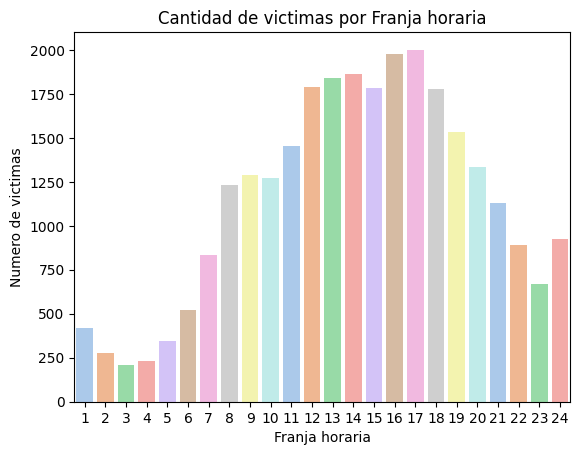

In [8]:
ax=sns.barplot(lesiones_df.groupby("franja_hora")["n_victimas"].sum()\
                          .reset_index().astype(int),
                x="franja_hora", y="n_victimas", palette="pastel")

ax.set_title("Cantidad de victimas por Franja horaria")
ax.set_xlabel("Franja horaria")
ax.set_ylabel("Numero de victimas")

**Curva de supervivencia en accidentes "graves"**

Analisis de supervivencia en lesiones viales.


$Definiciones$

* Evento: Definimos como evento cuando la lesion presenta una situacion **GRAVE**.

* Superviviente: Definimos superviviente cuando la lesion **NO** presenta una situacion grave.

Text(0, 0.5, 'Probabilidad de supervivencia')

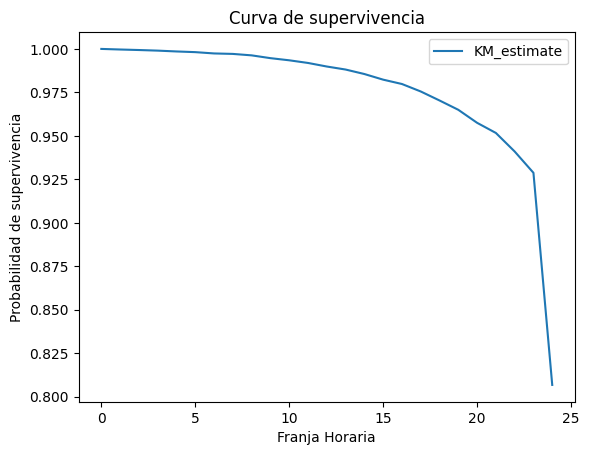

In [10]:
from lifelines import KaplanMeierFitter

df_tmp = lesiones_df[["gravedad", "franja_hora"]].copy()

# creamos el evento de interes --- 1 si es un accidente grave 0 cc.
df_tmp["lesion_accidente_grave"] = np.where(~df_tmp.gravedad.isna() , 1, 0)

# declaramos y entrenamos el modelo estadistico
kmf = KaplanMeierFitter()

kmf.fit(df_tmp[~df_tmp["franja_hora"].isna()][["franja_hora"]],
        df_tmp[~df_tmp["franja_hora"].isna()]["lesion_accidente_grave"])

ax=kmf.survival_function_.plot()
ax.set_title("Curva de supervivencia")
ax.set_xlabel("Franja Horaria")
ax.set_ylabel("Probabilidad de supervivencia")

Text(0, 0.5, 'Franja Horaria')

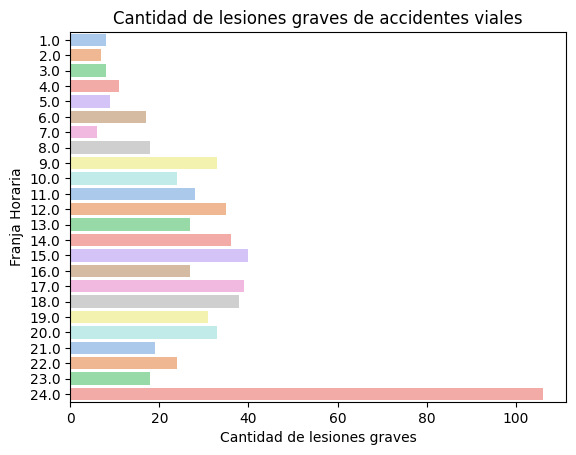

In [11]:
ax=sns.countplot(df_tmp[df_tmp.lesion_accidente_grave==1], palette="pastel", y="franja_hora")

ax.set_title("Cantidad de lesiones graves de accidentes viales")
ax.set_xlabel("Cantidad de lesiones graves")
ax.set_ylabel("Franja Horaria")

**Barrios con mayor porcentaje de accidentes**


In [12]:
# calculamos el porcentaje  de accidentes por barrio
lesiones_gp_barrio_df = lesiones_df.barrio_accidente.value_counts(normalize=True)\
                                                    .reset_index()\
                                                    .rename(columns={"index":"barrio",
                                                                     "barrio_accidente": "per_acc"})
lesiones_gp_barrio_df.per_acc.describe()

count    139.000000
mean       0.007194
std        0.012386
min        0.000185
25%        0.000185
50%        0.000185
75%        0.009804
max        0.071402
Name: per_acc, dtype: float64

Text(0, 0.5, 'Barrios')

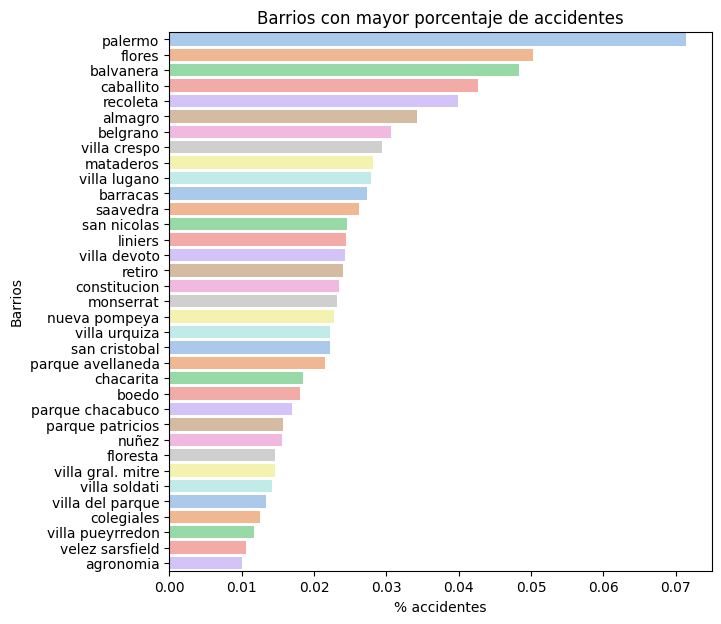

In [13]:
# Tomamos los barrios que poseen un porcentaje de accidentes mayores al 4 percentil
f=plt.figure(figsize=(7,7))
ax=sns.barplot(lesiones_gp_barrio_df[lesiones_gp_barrio_df.per_acc >
                                     lesiones_gp_barrio_df.per_acc.quantile(.75)],
            y="barrio", x="per_acc", palette="pastel")
ax.set_title("Barrios con mayor porcentaje de accidentes")
ax.set_xlabel("% accidentes")
ax.set_ylabel("Barrios")

**Hora media de ocurrencia de accidentes en top-barrios-accidentes**

**OBS:**
* Responder las sig preguntas: Es significativamente distinto el promedio de accidentes ocurridos a las 2 de la tarde vs 15 de la tarde?  

In [14]:
# obtenemos los barrios con mayor porcentaje de accidentes
top_barrios_accidentes =lesiones_gp_barrio_df[lesiones_gp_barrio_df.per_acc >
                                              lesiones_gp_barrio_df.per_acc.quantile(.75)].barrio

# obtenemos los reportes de accidentes en los barrios-top-acc
lesiones_top_barrios_acc_df = lesiones_df[lesiones_df.barrio_accidente.isin(top_barrios_accidentes)]

Text(0, 0.5, 'Barrios con mayor % de accidentes')

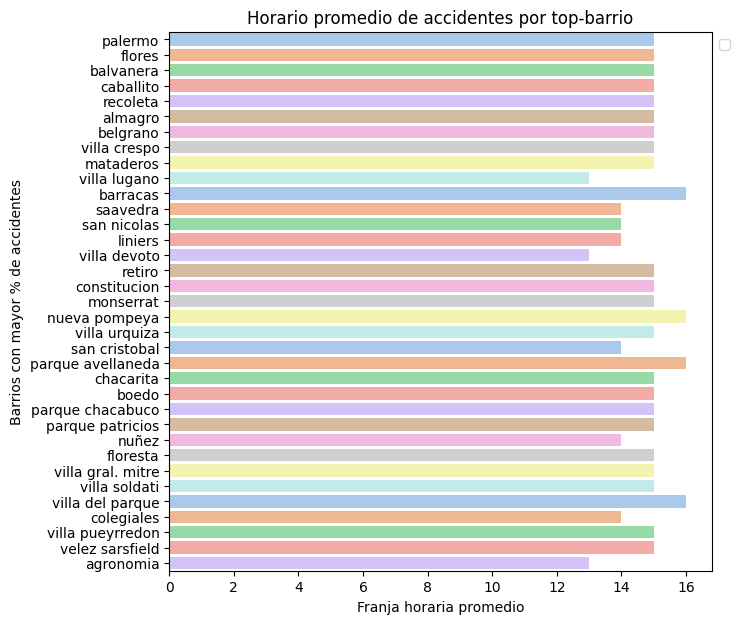

In [15]:
# calculamos la hora promedio en la que ocurren los accidentes
# en los barrios con mayor porcentaje de accidentes
hora_top_barrios_acc = lesiones_top_barrios_acc_df.groupby("barrio_accidente")["franja_hora"]\
                                                  .apply(lambda x: np.round(x.median(),0))\
                                                  .reset_index()
# ordenamos segun el porcentaje de accidentes
hora_top_barrios_acc['barrio_accidente'] =pd.Categorical(hora_top_barrios_acc['barrio_accidente'],
                                                         categories=top_barrios_accidentes, ordered=True)

f = plt.figure(figsize=(7,7))
ax=sns.barplot(hora_top_barrios_acc, y="barrio_accidente", x="franja_hora", palette="pastel")

plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
ax.set_title("Horario promedio de accidentes por top-barrio")
ax.set_xlabel("Franja horaria promedio")
ax.set_ylabel("Barrios con mayor % de accidentes")

In [16]:
# asi se soluciona el problema del reset index::
df_tipo_victima_x_Barrio = lesiones_top_barrios_acc_df.groupby(by="barrio_accidente")["victima"]\
                                                       .value_counts().reset_index(name='cantidad_victimas')
df_tipo_victima_x_Barrio.head()

,barrio_accidente,victima,cantidad_victimas
0,agronomia,MOTO,7
1,agronomia,AUTO,6
2,agronomia,PEATON,2
3,almagro,CICLISTA,26
4,almagro,MOTO,19


**Tipo de victima con mayor cantidad de accidentes por Barrio top**

In [17]:
# Calculamos el tipo de victima que se corresponde con la mayor cantidad de accidentes para cada barrio
df_top_tipo_victima_x_barrio = df_tipo_victima_x_Barrio.groupby(by="barrio_accidente")\
                                                       .apply(lambda x: df_tipo_victima_x_Barrio.loc[x.cantidad_victimas.idxmax()])\
                                                       .reset_index(drop=True)

df_top_tipo_victima_x_barrio.head()

,barrio_accidente,victima,cantidad_victimas
0,agronomia,MOTO,7
1,almagro,CICLISTA,26
2,balvanera,MOTO,30
3,barracas,CICLISTA,19
4,belgrano,MOTO,24


[Text(0, 0, ''),
 Text(0, 1, ''),
 Text(0, 2, ''),
 Text(0, 3, ''),
 Text(0, 4, ''),
 Text(0, 5, ''),
 Text(0, 6, ''),
 Text(0, 7, ''),
 Text(0, 8, ''),
 Text(0, 9, ''),
 Text(0, 10, ''),
 Text(0, 11, ''),
 Text(0, 12, ''),
 Text(0, 13, ''),
 Text(0, 14, ''),
 Text(0, 15, ''),
 Text(0, 16, ''),
 Text(0, 17, ''),
 Text(0, 18, ''),
 Text(0, 19, ''),
 Text(0, 20, ''),
 Text(0, 21, ''),
 Text(0, 22, ''),
 Text(0, 23, ''),
 Text(0, 24, ''),
 Text(0, 25, ''),
 Text(0, 26, ''),
 Text(0, 27, ''),
 Text(0, 28, ''),
 Text(0, 29, ''),
 Text(0, 30, ''),
 Text(0, 31, ''),
 Text(0, 32, ''),
 Text(0, 33, ''),
 Text(0, 34, '')]

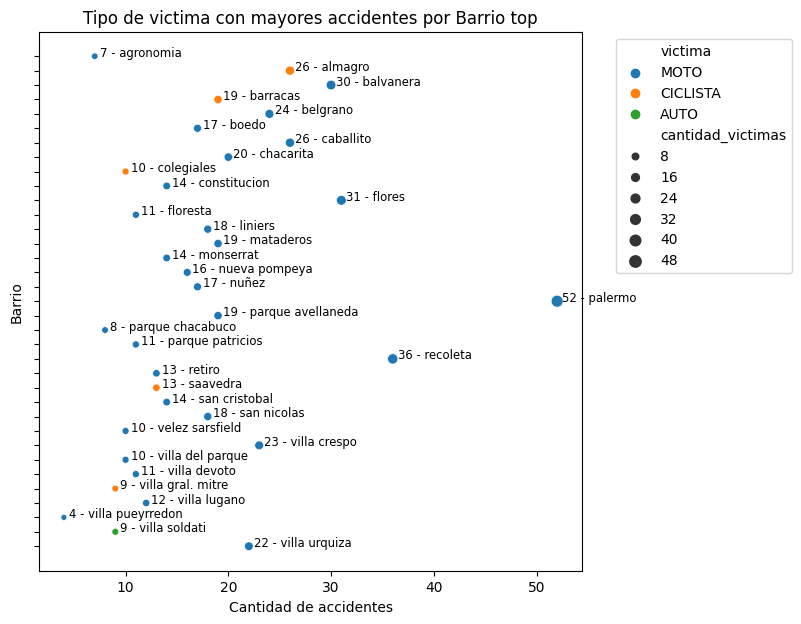

In [18]:
plt.figure(figsize=(7,7))
ax=sns.scatterplot(df_top_tipo_victima_x_barrio, size="cantidad_victimas",
                   y="barrio_accidente", x="cantidad_victimas", hue="victima")

ax.set_title("Tipo de victima con mayores accidentes por Barrio top")
ax.set_xlabel("Cantidad de accidentes")
ax.set_ylabel("Barrio")

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

# New code: Annotate each point with the number of accidents and neighborhood
for index, row in df_top_tipo_victima_x_barrio.iterrows():
    ax.text(
        x=row['cantidad_victimas']+0.5,
        y=row['barrio_accidente'],
        s=f"{row['cantidad_victimas']} - {row['barrio_accidente']}",
        horizontalalignment='left',
        size='small',
        color='black'
    )
ax.set_yticklabels([])

**Analizando victima y acusado**

In [19]:
# calculamos la cantidad totales de victimas en cada transporte
df_tipo_victima_x_Barrio.groupby(by="victima")["cantidad_victimas"].sum().reset_index()

,victima,cantidad_victimas
0,AUTO,265
1,CAMION,4
2,CAMIONETA,11
3,CICLISTA,363
4,MOTO,596
5,MOVIL,2
6,OTRO,7
7,PEATON,219
8,TRANSPORTE PUBLICO,90
9,UTILITARIO,2


**OBS:** Vemos que la mayoria de victimas de accidentes pertenecen al transporte de `moto` seguido de `ciclistas`.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'MOTO'),
  Text(1, 0, 'CICLISTA'),
  Text(2, 0, 'AUTO'),
  Text(3, 0, 'PEATON'),
  Text(4, 0, 'TRANSPORTE PUBLICO'),
  Text(5, 0, 'CAMIONETA'),
  Text(6, 0, 'OTRO'),
  Text(7, 0, 'CAMION'),
  Text(8, 0, 'MOVIL'),
  Text(9, 0, 'UTILITARIO')])

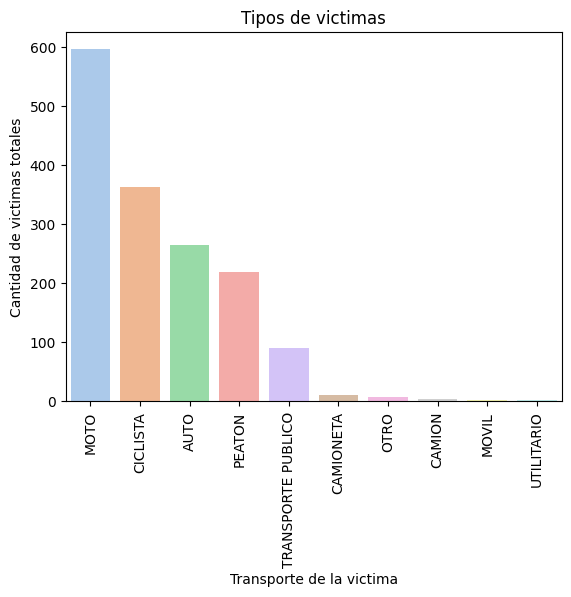

In [20]:
df_tipo_victima_total = df_tipo_victima_x_Barrio.groupby(by="victima")["cantidad_victimas"]\
                                                .sum().reset_index()\
                                                .sort_values(by="cantidad_victimas", ascending=False)

ax=sns.barplot(df_tipo_victima_total,
               x="victima", y="cantidad_victimas", palette="pastel")

ax.set_title("Tipos de victimas")
ax.set_xlabel("Transporte de la victima")
ax.set_ylabel("Cantidad de victimas totales")
plt.xticks(rotation=90)

**Distribuciones de accidentes per tipo de victima**

Confirmar la hipotesis de que ciertos tipos de victimas presentan una distribucion distinta en lo que respecta a la cantidad de accidentes

Vemos que **dependiendo el tipo de victima** hay **distintas distribuciones** en lo que respecta la **cantidad de accidentes**

Sera significante esta diferencia? ---> T-test

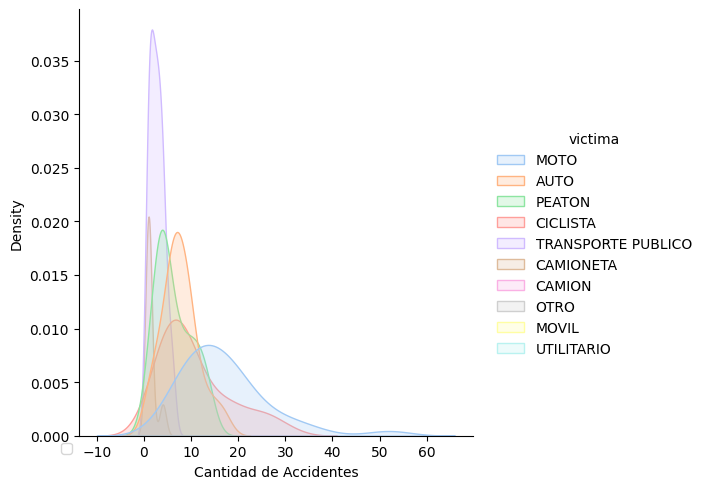

In [21]:
ax=sns.displot(df_tipo_victima_x_Barrio[["victima", "cantidad_victimas"]], warn_singular=False,
               color="r", x="cantidad_victimas",hue="victima", kind="kde", fill=True, palette="pastel")

ax.set_axis_labels("Cantidad de Accidentes")
plt.legend(bbox_to_anchor=(0, 0))

Text(0.5, 0, 'Cantidad de victimas')

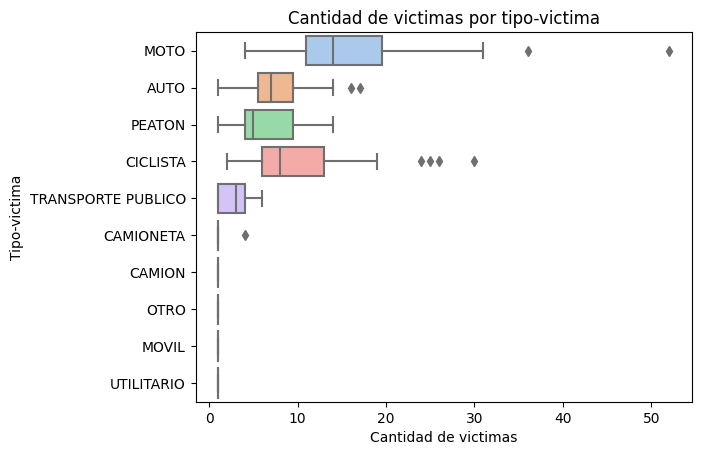

In [22]:
ax=sns.boxplot(df_tipo_victima_x_Barrio, palette="pastel",
               x="cantidad_victimas", y="victima")

ax.set_title("Cantidad de victimas por tipo-victima")
ax.set_ylabel("Tipo-victima")
ax.set_xlabel("Cantidad de victimas")

**Analizar franja horaria de accidentes per tipo de victima**

In [23]:
lesiones_top_barrios_per_franjaHora = lesiones_top_barrios_acc_df.groupby(by=["franja_hora", "victima"])\
                                                                 ["n_victimas"].sum().reset_index()

lesiones_top_barrios_per_franjaHora

,franja_hora,victima,n_victimas
0,1.0,AUTO,9
1,1.0,CICLISTA,4
2,1.0,MOTO,10
3,1.0,PEATON,1
4,2.0,AUTO,4
...,...,...,...
129,24.0,CAMIONETA,1
130,24.0,CICLISTA,5
131,24.0,MOTO,11
132,24.0,PEATON,7


Vemos que el la cantidad de accidentes dependiendo el tipo-victima cambia segun la franja horaria.  

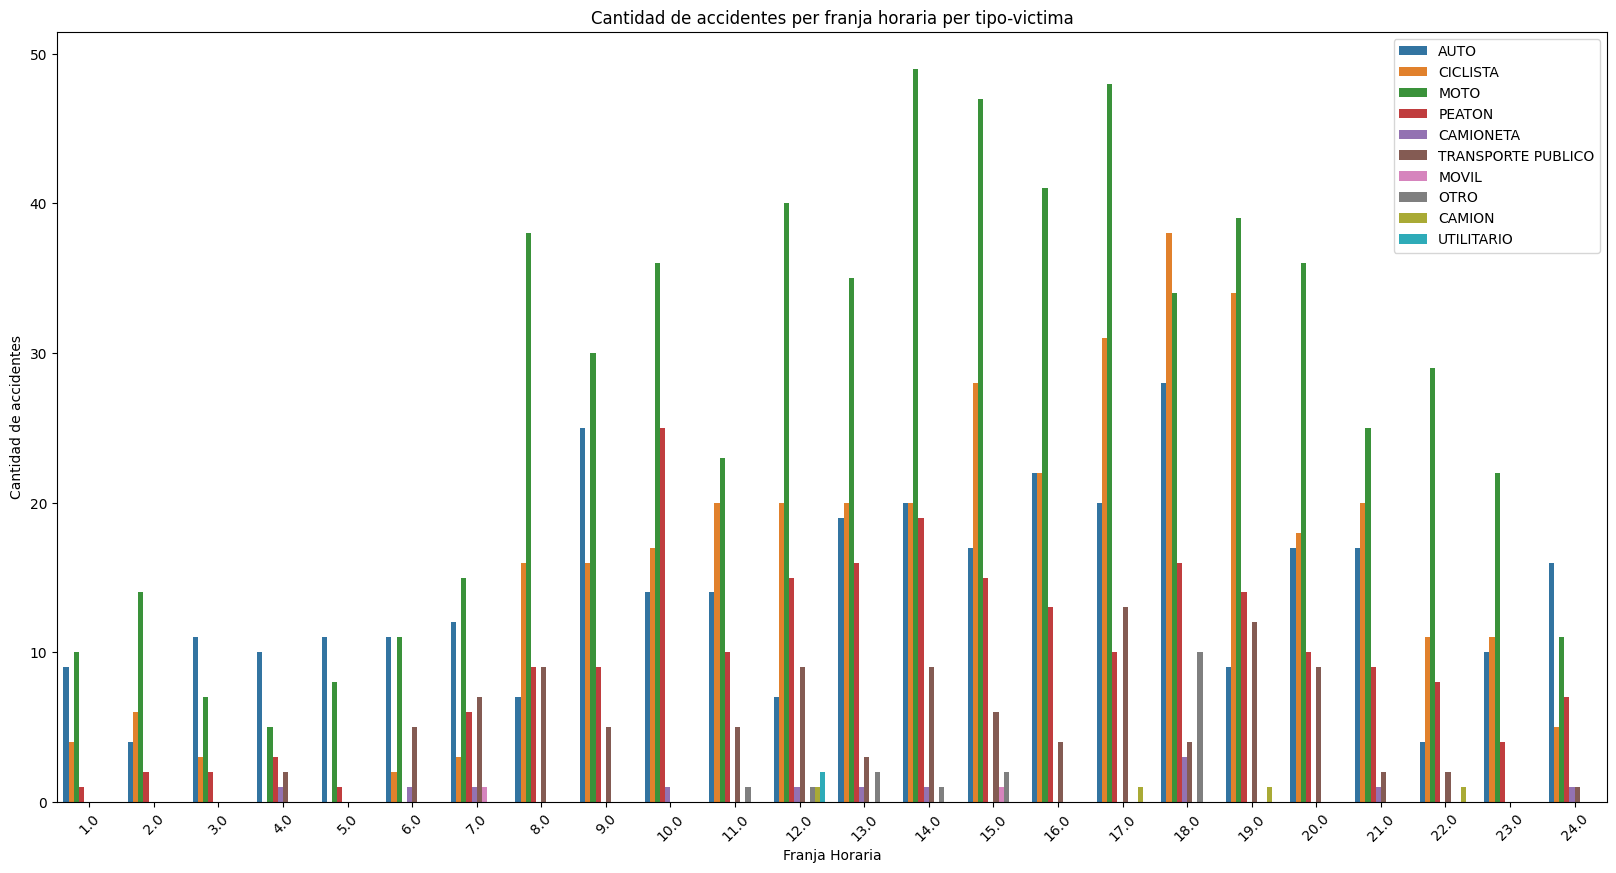

In [24]:
plt.figure(figsize=(20,10))
ax=sns.barplot(lesiones_top_barrios_per_franjaHora,
               x="franja_hora", y="n_victimas", hue="victima")

ax.set_title("Cantidad de accidentes per franja horaria per tipo-victima")
ax.set_xlabel("Franja Horaria")
ax.set_ylabel("Cantidad de accidentes")

plt.xticks(rotation=45)
plt.legend(loc='upper right')

In [90]:
## FALTA HACER:
# 1) implementar la prueba de hip de los sub-titulos anteriores

## DataFrame Homicidios

#### Tratamiento Nulos

In [25]:
# El str SD indica: SinDato por ende
# reemplazamos todas las ocurrencias de "SD" por nans
homicidios_df = homicidios_df.replace("SD", np.nan)
homicidios_df = homicidios_df.replace("sd", np.nan)
homicidios_df = homicidios_df.replace("nan", np.nan)
homicidios_df = homicidios_df.replace("", np.nan)
homicidios_df = homicidios_df.replace(" ", np.nan)

In [26]:
homicidios_df.isna().mean()

ID                       0.000000
N_VICTIMAS               0.000000
FECHA                    0.000000
AAAA                     0.000000
MM                       0.000000
DD                       0.000000
HORA                     0.001437
HH                       0.001437
LUGAR_DEL_HECHO          0.001437
TIPO_DE_CALLE            0.000000
Calle                    0.001437
Altura                   0.814655
Cruce                    0.245690
Dirección Normalizada    0.011494
COMUNA                   0.000000
XY (CABA)                0.000000
pos x                    0.000000
pos y                    0.000000
PARTICIPANTES            0.000000
VICTIMA                  0.012931
ACUSADO                  0.033046
dtype: float64

### Prepro

In [27]:
# Dropeamos columnas innecesarias que no aportan informacion
homicidios_df = homicidios_df.drop(columns=["AAAA", "MM", "DD"])

# cambiamos el tipo de la columna HH
homicidios_df.HH=pd.to_numeric(homicidios_df.HH)

def calculate_part_of_day(hour):
  """
  Calcula la "parte del dia" asociada a la hora pasada por input.
  """
  if (hour >= 0) & (hour < 6):
    return "Madrugada"

  elif (hour >= 6) & (hour < 12):
    return "Manana"

  elif (hour >= 12) & (hour < 19):
    return "Tarde"

  elif (hour >= 19) & (hour <= 23):
    return "Noche"

  else:
    return None

homicidios_df["part_of_day"] = homicidios_df.HH.transform(lambda x: calculate_part_of_day(x))

homicidios_df.head()

,ID,N_VICTIMAS,FECHA,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Altura,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,part_of_day
0,2016-0001,1,2016-01-01,04:00:00,4.0,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,PIEDRA BUENA AV.,NaN,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,Point (98896.78238426 93532.43437792),-58.47533969,-34.68757022,MOTO-AUTO,MOTO,AUTO,Madrugada
1,2016-0002,1,2016-01-02,01:15:00,1.0,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,"PAZ, GRAL. AV.",NaN,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,Point (95832.05571093 95505.41641999),-58.50877521,-34.66977709,AUTO-PASAJEROS,AUTO,PASAJEROS,Madrugada
2,2016-0003,1,2016-01-03,07:00:00,7.0,AV ENTRE RIOS 2034,AVENIDA,ENTRE RIOS AV.,2034.0,NaN,ENTRE RIOS AV. 2034,1,Point (106684.29090040 99706.57687843),-58.39040293,-34.63189362,MOTO-AUTO,MOTO,AUTO,Manana
3,2016-0004,1,2016-01-10,00:00:00,0.0,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,LARRAZABAL AV.,NaN,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,Point (99840.65224780 94269.16534422),-58.46503904,-34.68092974,MOTO-SD,MOTO,NaN,Madrugada
4,2016-0005,1,2016-01-21,05:20:00,5.0,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,SAN JUAN AV.,NaN,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,Point (106980.32827929 100752.16915795),-58.38718297,-34.62246630,MOTO-PASAJEROS,MOTO,PASAJEROS,Madrugada


Pasamos a calcular el barrio donde ocurrio dicho accidente.

Haremos web-scrapping en la pagina [link-coords](https://www.coordenadas.com.es/argentina/pueblos-de-ciudad-buenos-aires/7/1) asi obtendremos las coordenadas pertenecientes a cada Barrio para luego matchear con las de nuestro DataFrame y asi poder calcular el Barrio en cuestion.

In [28]:
def get_coordenates():
  """
  Consigue las coordenadas de los barrios de CABA.
  Webscrapping % parser. (from: 'https://www.coordenadas.com.es/argentina/pueblos-de-ciudad-buenos-aires/7/1')
  """
  # URL de la página
  url = 'https://www.coordenadas.com.es/argentina/pueblos-de-ciudad-buenos-aires/7/1'

  # Realizar una solicitud GET a la página
  response = requests.get(url).text

  soup = BeautifulSoup(response, 'html.parser')

  ciudades_coordenadas = soup.find('div', class_='table-responsive')\
                                  .find(class_='table').find('tbody')

  barrio_coordeanda = np.empty(86, dtype=[('str_elemento', 'U50'), ('str_elemento2', 'U50')])

  for tr, i in zip(ciudades_coordenadas.find_all('tr'), enumerate(ciudades_coordenadas.find_all('tr'))):
    for td, j in zip(tr.find_all('td'), enumerate(tr.find_all('td'))):
      barrio_coordeanda[i[0]][j[0]] = td.text

  return barrio_coordeanda

def clean_and_restructure_array(arr):
  """
  Limpia los strs de una lista de 2-uplas
  Devolviendo como ouput una 3-upla (barrio, coordenada1, coordenada2).
  """
  cleaned_array = []
  for item in arr:
      name = item[0].strip().replace("-", "")
      coords = item[1].split(",")
      lat, lon = map(float, coords)
      cleaned_array.append([name, lat, lon])
  return cleaned_array

from typing import List, Tuple

def encontrar_barrio_cercano(coordenadas: Tuple[float, float], barrios: List[List[str]]) -> str:
    """
    Encuentra el barrio más cercano a las coordenadas dadas.

    :param coordenadas: Un par de coordenadas (latitud, longitud).
    :param barrios: Lista de barrios con sus coordenadas.
    :return: Nombre del barrio más cercano.
    """
    min_distancia = float('inf')
    barrio_cercano = ""

    for barrio in barrios:

      # checkeamos que las coordenadas existan

      if (coordenadas[0] != np.nan and coordenadas[1] != np.nan):
        dist = ((barrio[1] - coordenadas[0])**2 + (barrio[2] - coordenadas[1])**2)**0.5

        if dist < min_distancia:
            min_distancia = dist
            barrio_cercano = barrio[0]

    return barrio_cercano

# Obtenemos las coordenadas de los barrios de CABA
original_coordenates = get_coordenates()

# Limpieza y reestructuración el array de (barrio, coordenada1, coordenada2)
barrio_coordeanda_cleaned = clean_and_restructure_array(original_coordenates)

In [29]:
# casteamos a float
homicidios_df["pos y"] = pd.to_numeric(homicidios_df["pos y"], errors='coerce')
homicidios_df["pos x"] = pd.to_numeric(homicidios_df["pos x"], errors='coerce')

homicidios_df["Barrio_deco"]=homicidios_df[["pos y", "pos x"]].apply(lambda x:encontrar_barrio_cercano( (x["pos y"], x["pos x"]),
                                                                          barrio_coordeanda_cleaned),
                                                                     axis=1)
# reemplazamos espacios en blanco y convertimos a minuscula
homicidios_df["Barrio_deco"]=homicidios_df.Barrio_deco.apply(lambda x: x.lower().replace(" ", ""))

In [30]:
homicidios_df.head()

,ID,N_VICTIMAS,FECHA,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Altura,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,part_of_day,Barrio_deco
0,2016-0001,1,2016-01-01,04:00:00,4.0,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,PIEDRA BUENA AV.,NaN,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,Point (98896.78238426 93532.43437792),-58.475340,-34.687570,MOTO-AUTO,MOTO,AUTO,Madrugada,luisjgarcia
1,2016-0002,1,2016-01-02,01:15:00,1.0,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,"PAZ, GRAL. AV.",NaN,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,Point (95832.05571093 95505.41641999),-58.508775,-34.669777,AUTO-PASAJEROS,AUTO,PASAJEROS,Madrugada,losperales
2,2016-0003,1,2016-01-03,07:00:00,7.0,AV ENTRE RIOS 2034,AVENIDA,ENTRE RIOS AV.,2034.0,NaN,ENTRE RIOS AV. 2034,1,Point (106684.29090040 99706.57687843),-58.390403,-34.631894,MOTO-AUTO,MOTO,AUTO,Manana,sancristobal
3,2016-0004,1,2016-01-10,00:00:00,0.0,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,LARRAZABAL AV.,NaN,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,Point (99840.65224780 94269.16534422),-58.465039,-34.680930,MOTO-SD,MOTO,NaN,Madrugada,luisjgarcia
4,2016-0005,1,2016-01-21,05:20:00,5.0,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,SAN JUAN AV.,NaN,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,Point (106980.32827929 100752.16915795),-58.387183,-34.622466,MOTO-PASAJEROS,MOTO,PASAJEROS,Madrugada,constitucion


In [31]:
homicidios_df.Barrio_deco.unique()

array(['luisjgarcia', 'losperales', 'sancristobal', 'constitucion',
       'almirantebrown', 'montecastro', 'buenosaires',
       'ciudadautonomadebuenosaires', 'barracas', 'ramonlfalcon',
       'parquechacabuco', 'villariachuelo', 'presidenteroquesaenzpena',
       'centro', 'saavedra', 'parquepatricios', 'balbastro',
       'comandantelpiedrabuena', 'balvanera', 'bonorino', 'calaza',
       'cafferata', '', 'villaortuzar', 'barrionorte', 'palermo',
       'villaluro', 'caballito', 'retiro', 'paternal', 'puertomadero',
       'nunez', 'liniers', 'villaurquiza', 'boedo', 'nuevapompeya',
       'floresta', 'parquechas', 'almagro', 'villadevoto', 'congreso',
       'mataderos', 'chacarita', 'marcelotorcuatodealvear', 'villareal',
       'generaljosedesanmartin', 'belgrano', 'boca', 'nazca', 'santelmo',
       'villageneralmitre', 'once', 'agronomia', 'puertonuevo',
       'villasantarita'], dtype=object)

### EDA

**Cantidad de Homicidios por Barrio**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54]),
 [Text(0, 0, 'sancristobal'),
  Text(1, 0, 'nuevapompeya'),
  Text(2, 0, 'boedo'),
  Text(3, 0, 'bonorino'),
  Text(4, 0, 'constitucion'),
  Text(5, 0, 'congreso'),
  Text(6, 0, 'liniers'),
  Text(7, 0, 'palermo'),
  Text(8, 0, 'parquechacabuco'),
  Text(9, 0, 'balbastro'),
  Text(10, 0, 'centro'),
  Text(11, 0, 'luisjgarcia'),
  Text(12, 0, 'almagro'),
  Text(13, 0, 'nunez'),
  Text(14, 0, 'santelmo'),
  Text(15, 0, 'almirantebrown'),
  Text(16, 0, 'barrionorte'),
  Text(17, 0, 'presidenteroquesaenzpena'),
  Text(18, 0, 'once'),
  Text(19, 0, 'calaza'),
  Text(20, 0, 'chacarita'),
  Text(21, 0, 'ciudadautonomadebuenosaires'),
  Text(22, 0, 'parquepatricios'),
  Text(23, 0, ''),
  Text(24, 0, 'saavedra'),
  Text(25, 0, 'cafferata'),
  T

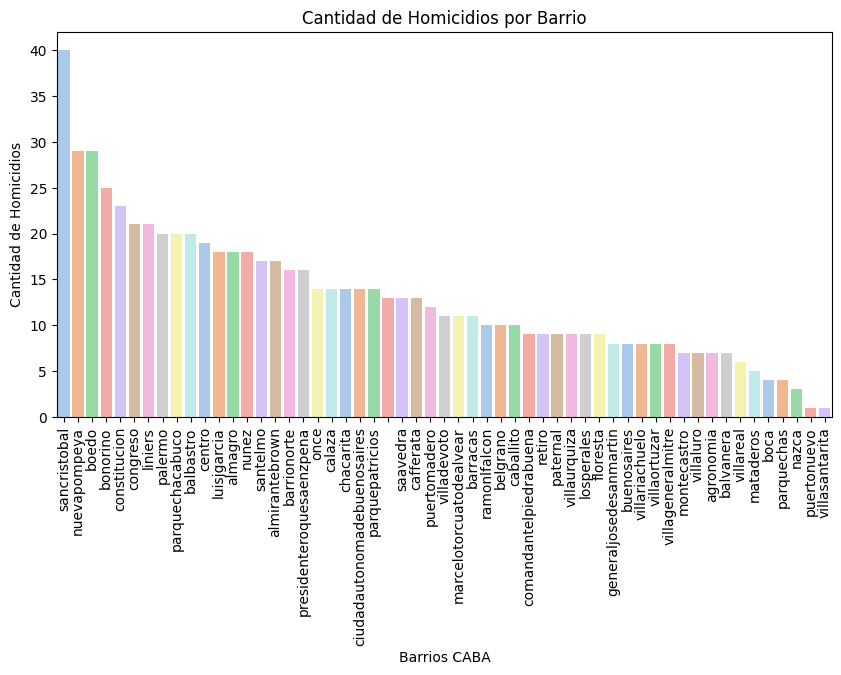

In [52]:
plt.figure(figsize=(10,5))

# calculamos la cantidad de victimas de homicidios en accidentes viales por barrio
gp_barrios_homicidios_df = homicidios_df.groupby(by="Barrio_deco")["N_VICTIMAS"].sum()\
                                        .reset_index()\
                                        .rename(columns={"N_VICTIMAS": "cantidad_homicidios"})\
                                        .sort_values(by="cantidad_homicidios", ascending=False)

ax=sns.barplot(gp_barrios_homicidios_df, palette="pastel",
               x="Barrio_deco", y="cantidad_homicidios")

ax.set_title("Cantidad de Homicidios por Barrio")
ax.set_ylabel("Cantidad de Homicidios")
ax.set_xlabel("Barrios CABA")

plt.xticks(rotation=90)

**Horas donde ocurren la mayoria de los homicidios por barrio mas peligroso**

In [60]:
# obtenemos el percentil 75 de barrios con mas homicidios
top_25per = np.quantile(gp_barrios_homicidios_df.cantidad_homicidios, 0.75)

# obtenemos el top 25% de barrios con mayores homicidios
top_25_per_barrios_homicidios = gp_barrios_homicidios_df[gp_barrios_homicidios_df.cantidad_homicidios > top_25per]["Barrio_deco"]

In [74]:
gp_hora_barrioTop_homicidios = homicidios_df[homicidios_df.Barrio_deco.isin(top_25_per_barrios_homicidios)]\
                                            .groupby(by=["HH", "Barrio_deco"])["N_VICTIMAS"].sum()\
                                            .reset_index().rename(columns={"N_VICTIMAS": "cantidad_homicidios"})\
                                            .sort_values(by=["cantidad_homicidios", "Barrio_deco"], ascending=False)



# tomamos de la hora en la que ocurren los homicidios por barrio
# luego redondeamos
gp_hora_barrioTop_homicidios = np.round(gp_hora_barrioTop_homicidios.groupby("Barrio_deco")\
                                                                    .agg({"HH": "mean",
                                                                          "cantidad_homicidios": "sum"}))\
                                                                    .reset_index()
gp_hora_barrioTop_homicidios.head()

,Barrio_deco,HH,cantidad_homicidios
0,almagro,12.0,18
1,balbastro,10.0,20
2,boedo,11.0,29
3,bonorino,13.0,25
4,centro,14.0,19


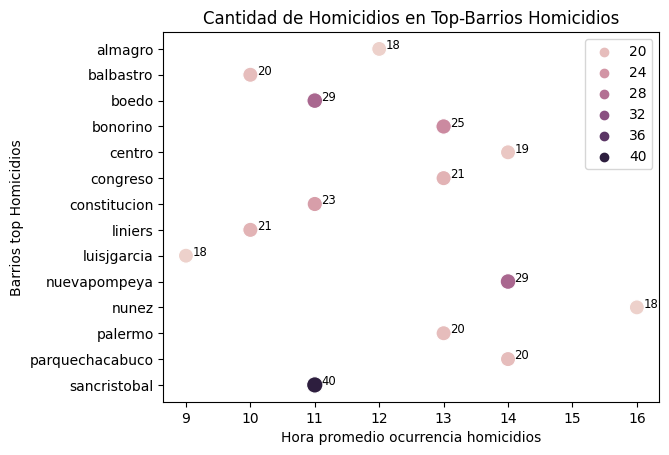

In [75]:
ax=sns.scatterplot(gp_hora_barrioTop_homicidios, s=gp_hora_barrioTop_homicidios.cantidad_homicidios+100,
                   y="Barrio_deco", x="HH", hue="cantidad_homicidios")

ax.set_title("Cantidad de Homicidios en Top-Barrios Homicidios")
ax.set_ylabel("Barrios top Homicidios")
ax.set_xlabel("Hora promedio ocurrencia homicidios")

# New code: Annotate each point with the number of accidents and neighborhood
# New code: Annotate each point with the number of accidents and neighborhood
for index, row in gp_hora_barrioTop_homicidios.iterrows():
    ax.text(
        x=row['HH']+0.1,
        y=row['Barrio_deco'],
        s=f"{row['cantidad_homicidios']}",
        horizontalalignment='left',
        size='small',
        color='black'
    )
plt.legend()

**Analisis por Madrugada-Manana-Tarde-Noche**

In [77]:
gp_part_of_day_barrioTop_homicidios = homicidios_df[homicidios_df.Barrio_deco.isin(top_25_per_barrios_homicidios)]\
                                                  .groupby(by=["Barrio_deco", "part_of_day"])["N_VICTIMAS"].sum()\
                                                  .reset_index().rename(columns={"N_VICTIMAS": "cantidad_homicidios"})

gp_part_of_day_barrioTop_homicidios.head()

,Barrio_deco,part_of_day,cantidad_homicidios
0,almagro,Madrugada,3
1,almagro,Manana,6
2,almagro,Noche,3
3,almagro,Tarde,6
4,balbastro,Madrugada,4


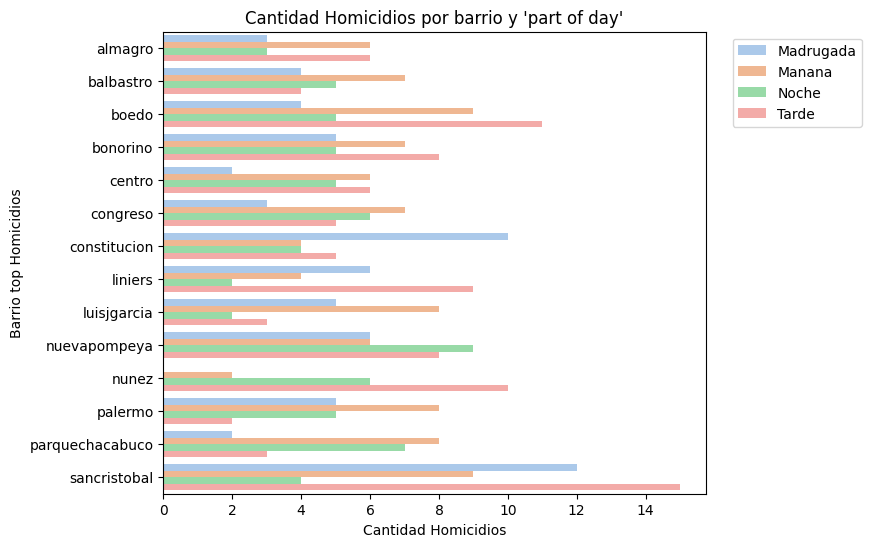

In [78]:
plt.figure(figsize=(7,6))
ax=sns.barplot(gp_part_of_day_barrioTop_homicidios, palette="pastel",
               y="Barrio_deco", x="cantidad_homicidios", hue="part_of_day")

ax.set_title("Cantidad Homicidios por barrio y 'part of day'")
ax.set_xlabel("Cantidad Homicidios")
ax.set_ylabel("Barrio top Homicidios")
ax.legend(bbox_to_anchor=(1.3, 1.0))

**Tipos de acusados & victimas**

In [79]:
# calculamos la cantidad de homicidios por (barrio x victima)
gp_victima_barrioTop_homicidios = homicidios_df[homicidios_df.Barrio_deco.isin(top_25_per_barrios_homicidios)]\
                                              .groupby(by=["Barrio_deco", "VICTIMA"])["N_VICTIMAS"].sum()\
                                              .reset_index().rename(columns={"N_VICTIMAS":"cantidad_homicidios"})

# calculamos la cantidad de homicidios por (barrio x acusado)
gp_acusado_barrioTop_homicidios = homicidios_df[homicidios_df.Barrio_deco.isin(top_25_per_barrios_homicidios)]\
                                              .groupby(by=["Barrio_deco", "ACUSADO"])["N_VICTIMAS"].sum()\
                                              .reset_index().rename(columns={"N_VICTIMAS":"cantidad_homicidios"})

gp_acusado_barrioTop_homicidios.head()

,Barrio_deco,ACUSADO,cantidad_homicidios
0,almagro,AUTO,8
1,almagro,BICICLETA,1
2,almagro,CARGAS,4
3,almagro,MOTO,3
4,almagro,PASAJEROS,2


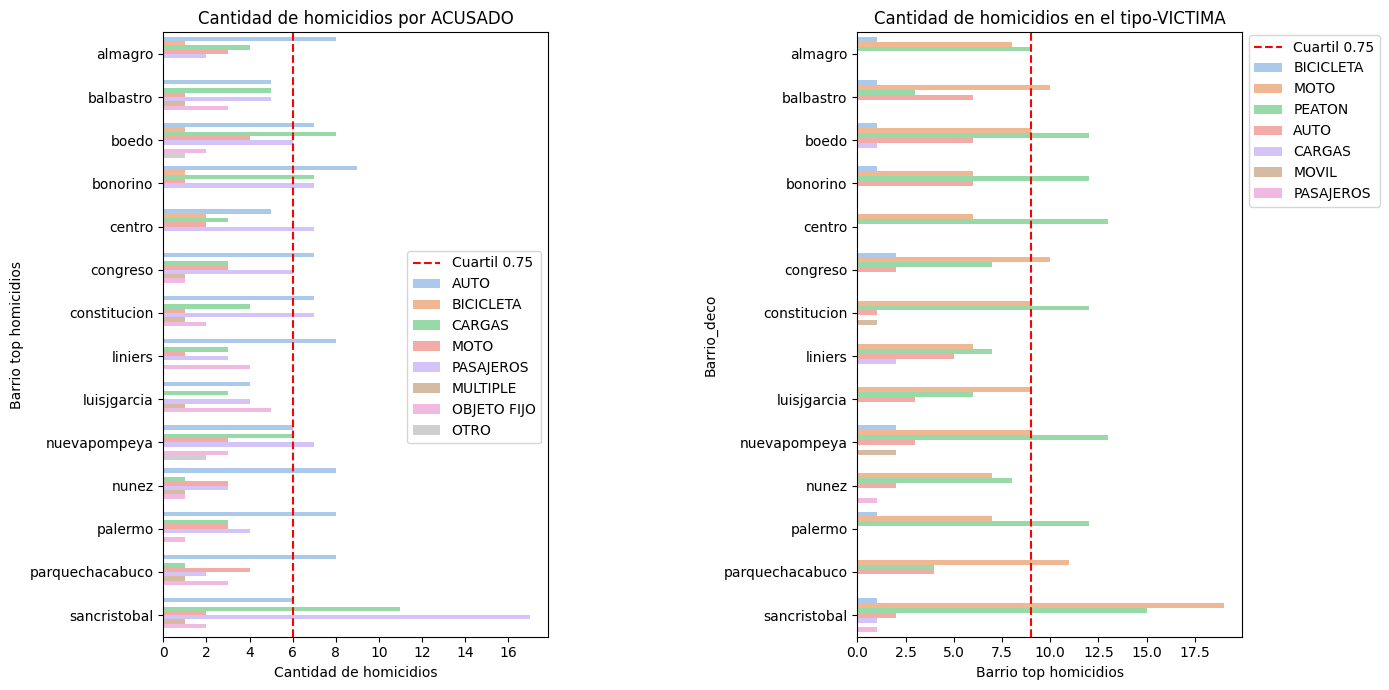

In [80]:
f, axs = plt.subplots(1,2, figsize=(14, 7))

sns.barplot(gp_acusado_barrioTop_homicidios, hue="ACUSADO", ax=axs[0],
            x="cantidad_homicidios", y="Barrio_deco", palette="pastel")


axs[0].axvline(gp_acusado_barrioTop_homicidios.cantidad_homicidios.quantile(0.75),
               0,1, linestyle="--", color="red", label="Cuartil 0.75")
axs[0].set_title("Cantidad de homicidios por ACUSADO")
axs[0].set_xlabel("Cantidad de homicidios")
axs[0].set_ylabel("Barrio top homicidios")
axs[0].legend(bbox_to_anchor=(1, 0.65))

sns.barplot(gp_victima_barrioTop_homicidios, hue="VICTIMA", ax=axs[1],
            x="cantidad_homicidios", y="Barrio_deco", palette="pastel")

axs[1].axvline(gp_victima_barrioTop_homicidios.cantidad_homicidios.quantile(0.75),
               0,1, linestyle="--", color="red", label="Cuartil 0.75")

axs[1].set_title("Cantidad de homicidios en el tipo-VICTIMA")
axs[1].set_xlabel("Cantidad de homicidios")
axs[1].set_xlabel("Barrio top homicidios")
axs[1].legend(bbox_to_anchor=(1, 0.7))
plt.tight_layout()